In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\example_trajectories")

include = [1, 3, 4, 6, 7, 8]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]
earliest_frames = [25, 48, 43, 63, 80, 30]

print(df.columns)

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:01,  1.99it/s]

[  0  50  80 140 200 280] 0 283


reading spots dfs: 4it [00:02,  1.86it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:03,  1.11it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:05,  1.27it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:06,  1.07it/s]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 14it [00:08,  1.68it/s]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'status', 'source', 'is_parent', 'is_child',
       'pseudotime', 'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP',
       'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


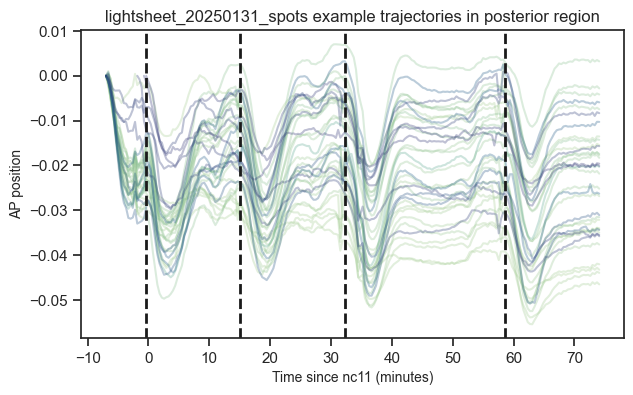

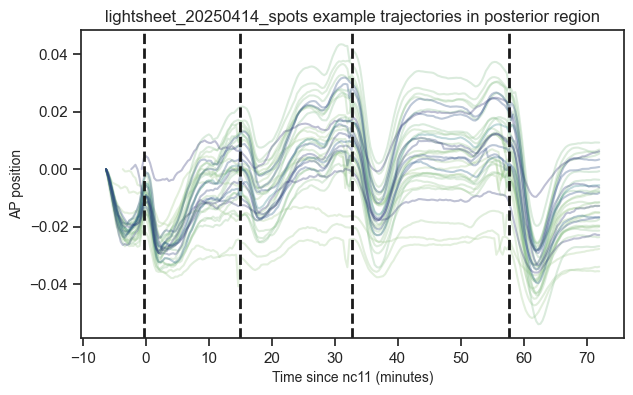

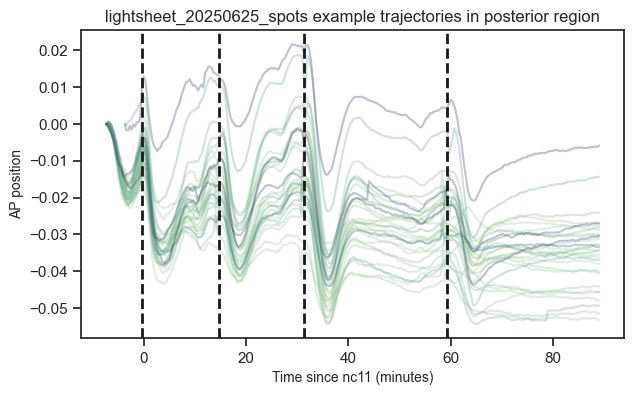

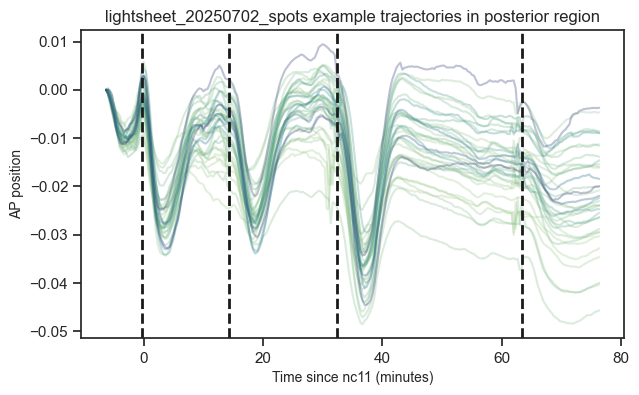

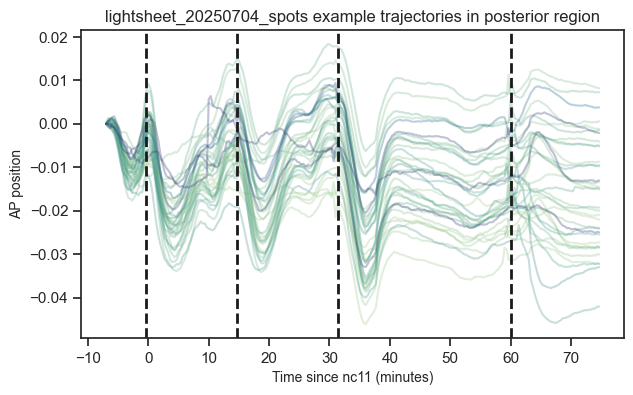

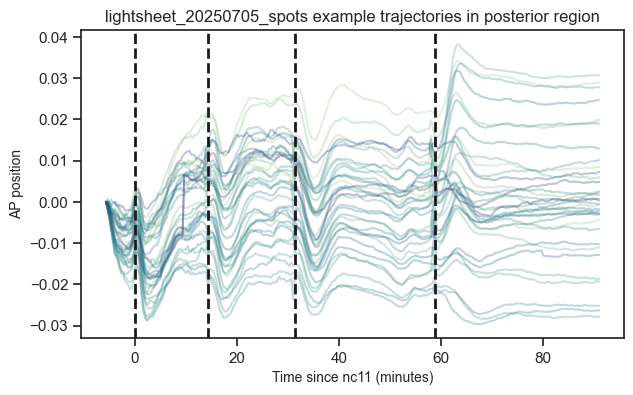

In [16]:
for k, df in enumerate(spots_dfs):
    df = df.copy()
    df = df[df["frame"] >= earliest_frames[k]]
    spots_dfs[k] = df

    t = df.groupby(["track_id", "frame"])[["x", "y", "z", "time_since_nc11", "AP", "theta", "distance", "cycle_pseudotime", "cycle"]].mean().reset_index()

    t["AP_from_start"] = t["AP"] - t["track_id"].map(t.groupby("track_id")["AP"].first())

    region_track_ids = t[t["AP"].between(0.05, 0.20)]["track_id"].unique()
    early_track_ids = t.groupby("track_id")["time_since_nc11"].min() < 0
    early_track_ids = t["track_id"].unique()[early_track_ids]
    low_distance = t.groupby("track_id")["distance"].mean() < 3.0
    low_distance = t["track_id"].unique()[low_distance]

    all_good = np.intersect1d(np.intersect1d(region_track_ids, early_track_ids), low_distance)

    np.random.seed(42)
    sampled_tracks = np.random.choice(all_good, 50)

    t = t[t["track_id"].isin(sampled_tracks)].copy()

    fig, axes = plt.subplots(figsize=(7, 4))

    sns.lineplot(t, x="time_since_nc11", y="AP_from_start", hue="track_id", errorbar=None, palette="crest", alpha=0.3, legend=False)

    for cycle in cycles[1:]:
        cycle_df = t[t["cycle"] == cycle]
        cycle_times = cycle_df.groupby("track_id")["time_since_nc11"].min()
        division_time = cycle_times.median()
        plt.axvline(division_time, color="k", linestyle="--", linewidth=2)

    plt.title(f"{stems[k]} example trajectories in posterior region")
    plt.ylabel("AP position")
    plt.xlabel("Time since nc11 (minutes)")
    # plt.ylim(-0.03, 0.13)
    plt.savefig(save_path / f"{stems[k]}_example_trajectories_posterior_region_overview.png", dpi=300, bbox_inches="tight")
    plt.show()

In [30]:
k = 0

for k, df in enumerate(spots_dfs):
    df = df.copy()
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    df = df[df["frame"] > min_mvmt_frames[0]]

    frame_map = lambda f: (f - df["frame"].min()) * metadatas[k]["seconds_per_frame"] / 60.0
    df["time"] = (df["frame"] - df["frame"].min()) * metadatas[k]["seconds_per_frame"] / 60.0

    t = df.groupby(["track_id", "frame"])[["x", "y", "z", "time_since_nc11", "AP", "theta", "distance", "cycle_pseudotime", "cycle", "time"]].mean().reset_index()
    t["time"] = np.round(t["time"], 3)
    t["AP_from_start"] = t["AP"] - t["track_id"].map(t.groupby("track_id")["AP"].first())

    # identify track ids that start early and aren't too weird
    early_track_ids = t.groupby("track_id")["time_since_nc11"].min() < 0
    early_track_ids = t["track_id"].unique()[early_track_ids]
    low_distance = t.groupby("track_id")["distance"].mean() < 3.0
    low_distance = t["track_id"].unique()[low_distance]

    for region, bounds in zip(["anterior", "middle", "posterior"], [(0.1, 0.2), (0.45, 0.55), (0.8, 0.9)]):

        region_track_ids = t[t["AP"].between(*bounds)]["track_id"].unique()
        all_good = np.intersect1d(np.intersect1d(region_track_ids, early_track_ids), low_distance)

        np.random.seed(42)
        t_region = t[t["track_id"].isin(all_good)].copy()

        division_times = []

        # indentify division times within the region
        for i, nc in enumerate(cycles):

            t_nc = t_region[t_region["frame"] == min_mvmt_frames[i]].set_index("track_id")

            if nc < 14:
                cycle_df = t_region[t_region["cycle"] == nc]
                cycle_df = cycle_df[cycle_df["distance"] < 3.0]
                cycle_times = cycle_df.groupby("track_id")["frame"].min()

            else:
                cycle_df = t_region[t_region["cycle"] == 13]
                cycle_df = cycle_df[cycle_df["distance"] < 3.0]
                cycle_times = cycle_df.groupby("track_id")["frame"].max()

            division_times.append(cycle_times.mean())

        fig, ax = plt.subplots(figsize=(5, 4))

        for frame in division_times:
            plt.axvline(frame_map(frame), color="k", linestyle="--", linewidth=2)

        sampled_tracks = np.random.choice(all_good, 10)
        t_ss = t[t["track_id"].isin(sampled_tracks)].copy()

        sns.lineplot(t_ss, x="time", y="AP_from_start", hue="track_id", errorbar=None, palette="crest", alpha=0.2, lw=2)
        sns.lineplot(t_region, x="time", y="AP_from_start", errorbar=None, color = sns.color_palette("crest", as_cmap=True)(0.5), lw=3)

        plt.gca().get_legend().remove()

        plt.title(f"{region.capitalize()} region")
        plt.ylabel("Total AP movement")
        plt.xlabel("Time (minutes)")
        plt.ylim(-0.05, 0.10)

        plt.savefig(save_path / f"{stems[k]}_example_trajectories_{region}_region.png", dpi=300, bbox_inches="tight")

        plt.close()

In [93]:
import napari
df = spots_dfs[-2]
viewer = napari.Viewer(ndisplay=3)
color = [dnt.palettes.nc[cycle] for cycle in df["cycle"].values]
viewer.add_points(df[["frame", "z", "y", "x"]].values, size=df["radius"]*2.2, face_color=color, border_color="k", border_width=0.1)
napari.run()

       frame  next_stop  prev_stop
18138     21       29.0        NaN
18139     22       29.0        NaN
18140     23       29.0        NaN
18141     24       29.0        NaN
18142     25       29.0        NaN
...      ...        ...        ...
87242    316        NaN      290.0
87243    317        NaN      290.0
87244    318        NaN      290.0
87245    319        NaN      290.0
87246    320        NaN      290.0

[2741 rows x 3 columns]
[nan, np.float64(47.0), np.float64(89.88888888888889), np.float64(142.33333333333334), np.float64(220.22222222222223)]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_15924\1093610424.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.1596765  3.17624624 2.91874645 2.25993273 1.78999754 1.04447744
 0.75352265 0.6905909  0.         7.66537086 7.36579833 6.53501904
 5.54416103 5.27225438 4.91999356 4.60274123 3.61623097 3.08151872
 2.41523534 2.27382013 1.95680904 1.68383478 1.12773262 0.94471337
 0.42635224 0.         5.27591104 4.93896042 4.09628217 3.4863707
 2.56700328 2.16108032 1.79505586 1.68884696 1.53530059 1.24636985
 1.19400951 0.53855212 0.         6.80573875 6.46590314 5.90907213
 5.60964368 4.87089462 4.90656489 4.30887635 4.49109634 4.15409766
 3.53847573 3.00076511 2.64033416 2.15248126 1.89252412 1.38560129
 0.78746704 0.         6.73084012 6.13405415 5.5995344  6.06369778
 5.04097589 4.64164763 3.75093955 2.92005536 2.33410063 2.05537484
 1.66344394 1.414506   0.76576918 0.         9.667409   9.057258

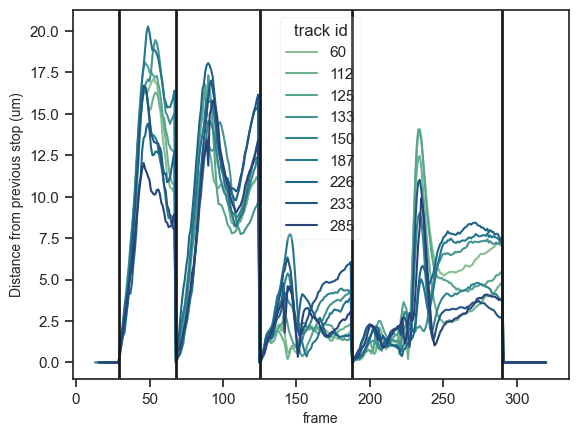

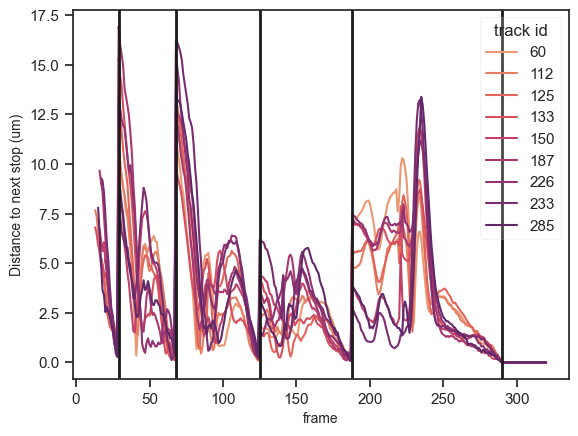

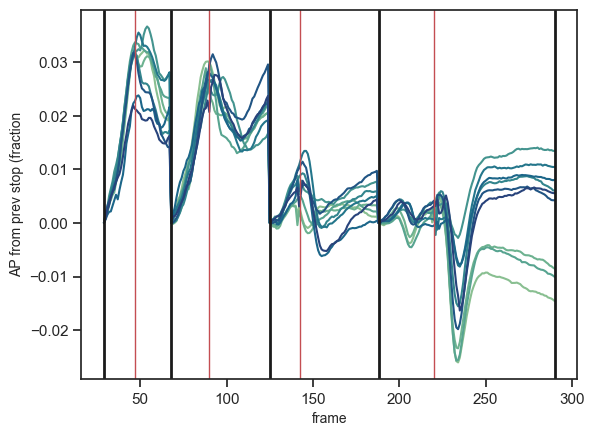

In [30]:
k = 5
df = spots_dfs[k]

min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
t = df.groupby(["track_id", "frame"])[["x", "y", "z", "time_since_nc11", "AP", "theta", "distance", "cycle_pseudotime", "cycle"]].mean().reset_index()

# returns the next mvmt frame for a given frame
map_next = lambda x: min_mvmt_frames[np.searchsorted(min_mvmt_frames, x, side="right")] if x < max(min_mvmt_frames) else np.nan
map_prev = lambda x: min_mvmt_frames[np.searchsorted(min_mvmt_frames, x, side="left") -1] if x > min(min_mvmt_frames) else np.nan

t["next_stop"] = t["frame"].map(map_next)
t["prev_stop"] = t["frame"].map(map_prev)

t["frames_to_next"] = t["next_stop"] - t["frame"]
t["frames_from_prev"] = t["frame"] - t["prev_stop"]

t["dist_to_next"] = 0.
t["dist_from_prev"] = 0.
t["gap_distance"] = 0.

region_track_ids = t[t["AP"] > 0.8]["track_id"].unique()
early_track_ids = t.groupby("track_id")["time_since_nc11"].min() < 0
early_track_ids = t["track_id"].unique()[early_track_ids]
low_distance = t.groupby("track_id")["distance"].mean() < 3.0
low_distance = t["track_id"].unique()[low_distance]

all_good = np.intersect1d(np.intersect1d(region_track_ids, early_track_ids), low_distance)

np.random.seed(42)
sampled_tracks = np.random.choice(all_good, 10)


t = t[t["track_id"].isin(sampled_tracks)].copy()

division_times = []

print(t[["frame", "next_stop", "prev_stop"]])

for i, nc in enumerate(cycles):

    t_nc = t[t["frame"] == min_mvmt_frames[i]].set_index("track_id")

    for axis in ["x", "y", "z", "AP"]:
        t[f"d{nc}{axis}"] = t[axis] - t["track_id"].map(t_nc[axis])

    t[f"{nc}_dist"] = np.sqrt(t[f"d{nc}x"]**2 + t[f"d{nc}y"]**2 + t[f"d{nc}z"]**2)

    # sns.lineplot(t, x="frame", y=f"{nc}_dist", errorbar=None, color=dnt.palettes.nc[nc], label=nc)

    if nc < 14:
        cycle_df = t[t["cycle"] == nc]
        cycle_df = cycle_df[cycle_df["distance"] < 3.0]
        cycle_times = cycle_df.groupby("track_id")["frame"].min()

    else:
        cycle_df = t[t["cycle"] == 13]
        cycle_df = cycle_df[cycle_df["distance"] < 3.0]
        cycle_times = cycle_df.groupby("track_id")["frame"].max()

    division_times.append(cycle_times.mean())

    if i < len(cycles) - 1:
        t_nc_next = t[t["frame"] == min_mvmt_frames[i + 1]].set_index("track_id")
        t[f"{nc}-{nc+1}"] = t["track_id"].map(t_nc_next[f"{nc}_dist"])

    if i > 0:
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "dist_from_prev"] = t[f"{nc - 1}_dist"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "dist_to_next"] = t[f"{nc}_dist"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "gap_distance"] = t[f"{nc-1}-{nc}"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "AP_from_prev"] = t[f"d{nc -1}AP"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "AP_to_next"] = t[f"d{nc}AP"]

    else:
        t.loc[t["frame"] <= min_mvmt_frames[i], "dist_to_next"] = t[f"{nc}_dist"]


print(division_times)

(save_path / stems[k]).mkdir(exist_ok=True)

t["sum_distance"] = t["dist_to_next"] + t["dist_from_prev"]
t["track_id"] = pd.Categorical(t["track_id"])

sns.lineplot(t, x="frame", y="dist_from_prev", hue="track_id", errorbar=None, palette="crest")
for frame in min_mvmt_frames:
    plt.axvline(frame, color="k", linestyle="-", linewidth=2)
plt.legend(title="track id")
plt.ylabel("Distance from previous stop (um)")
plt.xlabel("frame")
plt.savefig(save_path  / stems[k] / "nc_movement_distance_from_previous_stop.png", dpi=300)
plt.show()

sns.lineplot(t, x="frame", y="dist_to_next", hue="track_id", errorbar=None, palette="flare")
for frame in min_mvmt_frames:
    plt.axvline(frame, color="k", linestyle="-", linewidth=2)
plt.legend(title="track id")
plt.ylabel("Distance to next stop (um)")
plt.xlabel("frame")
plt.savefig(save_path  / stems[k] / "nc_movement_distance_to_next_stop.png", dpi=300)
plt.show()

sns.lineplot(t, x="frame", y="AP_from_prev", hue="track_id", errorbar=None, palette="crest")
for frame in min_mvmt_frames:
    plt.axvline(frame, color="k", linestyle="-", linewidth=2)
for frame in division_times:
    plt.axvline(frame, color="r", linestyle="-", linewidth=1)
plt.gca().get_legend().remove()
plt.ylabel("AP from prev stop (fraction")
plt.xlabel("frame")
plt.savefig(save_path / stems[k] / "nc_movement_ap_from_prev.png", dpi=300)
plt.show()


## Bad and quick

       frame  next_stop  prev_stop
3380      65       83.0        NaN
3381      66       83.0        NaN
3382      67       83.0        NaN
3383      68       83.0        NaN
3384      69       83.0        NaN
...      ...        ...        ...
96390    321      324.0      250.0
96391    322      324.0      250.0
96392    323      324.0      250.0
96393    324        NaN      250.0
96394    325        NaN      324.0

[12092 rows x 3 columns]


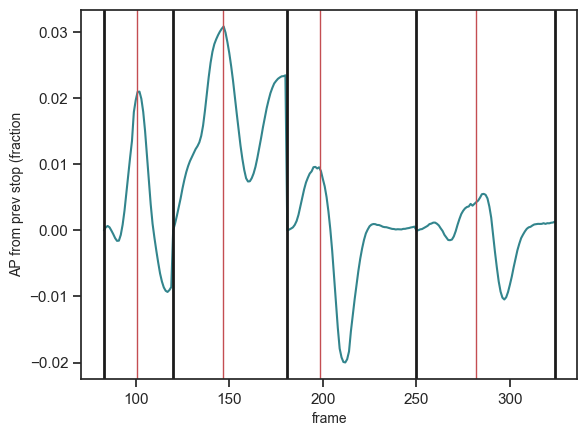

In [38]:
k = 4
df = spots_dfs[k]

min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
t = df.groupby(["track_id", "frame"])[["x", "y", "z", "time_since_nc11", "AP", "theta", "distance", "cycle_pseudotime", "cycle"]].mean().reset_index()

# returns the next mvmt frame for a given frame
map_next = lambda x: min_mvmt_frames[np.searchsorted(min_mvmt_frames, x, side="right")] if x < max(min_mvmt_frames) else np.nan
map_prev = lambda x: min_mvmt_frames[np.searchsorted(min_mvmt_frames, x, side="left") -1] if x > min(min_mvmt_frames) else np.nan

t["next_stop"] = t["frame"].map(map_next)
t["prev_stop"] = t["frame"].map(map_prev)

t["frames_to_next"] = t["next_stop"] - t["frame"]
t["frames_from_prev"] = t["frame"] - t["prev_stop"]

t["dist_to_next"] = 0.
t["dist_from_prev"] = 0.
t["gap_distance"] = 0.

region_track_ids = t[t["AP"].between(0.05, 0.95)]["track_id"].unique()
early_track_ids = t.groupby("track_id")["time_since_nc11"].min() < 0
early_track_ids = t["track_id"].unique()[early_track_ids]
low_distance = t.groupby("track_id")["distance"].mean() < 3.0
low_distance = t["track_id"].unique()[low_distance]

all_good = np.intersect1d(np.intersect1d(region_track_ids, early_track_ids), low_distance)

np.random.seed(42)
sampled_tracks = np.random.choice(all_good, 50)


t = t[t["track_id"].isin(sampled_tracks)].copy()

division_times = []

print(t[["frame", "next_stop", "prev_stop"]])

for i, nc in enumerate(cycles):

    t_nc = t[t["frame"] == min_mvmt_frames[i]].set_index("track_id")

    for axis in ["x", "y", "z", "AP"]:
        t[f"d{nc}{axis}"] = t[axis] - t["track_id"].map(t_nc[axis])

    t[f"{nc}_dist"] = np.sqrt(t[f"d{nc}x"]**2 + t[f"d{nc}y"]**2 + t[f"d{nc}z"]**2)

    if nc < 14:
        cycle_df = t[t["cycle"] == nc]
        cycle_df = cycle_df[cycle_df["distance"] < 3.0]
        cycle_times = cycle_df.groupby("track_id")["frame"].min()

    else:
        cycle_df = t[t["cycle"] == 13]
        cycle_df = cycle_df[cycle_df["distance"] < 3.0]
        cycle_times = cycle_df.groupby("track_id")["frame"].max()

    division_times.append(cycle_times.mean())

    if i < len(cycles) - 1:
        t_nc_next = t[t["frame"] == min_mvmt_frames[i + 1]].set_index("track_id")
        t[f"{nc}-{nc+1}"] = t["track_id"].map(t_nc_next[f"{nc}_dist"])

    if i > 0:
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "dist_from_prev"] = t[f"{nc - 1}_dist"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "dist_to_next"] = t[f"{nc}_dist"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "gap_distance"] = t[f"{nc-1}-{nc}"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "AP_from_prev"] = t[f"d{nc -1}AP"]
        t.loc[t["frame"].between(min_mvmt_frames[i - 1], min_mvmt_frames[i]), "AP_to_next"] = t[f"d{nc}AP"]

    else:
        t.loc[t["frame"] <= min_mvmt_frames[i], "dist_to_next"] = t[f"{nc}_dist"]

(save_path / stems[k]).mkdir(exist_ok=True)

t["track_id"] = pd.Categorical(t["track_id"])

sns.lineplot(t, x="frame", y="AP_from_prev", errorbar=None, color = sns.color_palette("crest", as_cmap=True)(0.5))
for frame in min_mvmt_frames:
    plt.axvline(frame, color="k", linestyle="-", linewidth=2)
for frame in division_times:
    plt.axvline(frame, color="r", linestyle="-", linewidth=1)

plt.ylabel("AP from prev stop (fraction")
plt.xlabel("frame")
plt.savefig(save_path / stems[k] / "all_nc_movement_ap_from_prev.png", dpi=300)
plt.show()
